In [19]:
%matplotlib inline

import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from matplotlib import cm, transforms

import keras
from keras.datasets import mnist
from keras.models import Model

from keras import optimizers

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base
import time

from IPython.core.display import display, HTML
from innvestigate.tools import Perturbation, PerturbationAnalysis

eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

# Introduction

In this experiment, we are going to build a sentiment analysis classifer, similar to [Arras et al. (2017a)][arras]. In particular, we are going to predict sentiments of movie reviews, and apply explanation methods provided by **iNNvestigate** to analyze which words in each sentence influence the prediction of sentiments.

The dataset that we are going to use is [Standford Sentiment Treebank][standford]. Although the original dataset contains reviews in 5 categories: *very negative, negative, neutral, positive,* and *very positive*, *neutral* reviews are excluded and we are here only interested whether reviews are positive or negative. In other words, we are going to build a binary classification. 


In the following, we first download a prepared dataset to local and load it to the notebook. Then, we construct a neural network model, receiving reviews as input and predicting their sentiments. Finally, we apply various explanation methods implemented in iNNvestigate to explain decisions of models. Below is an example of a explanation where red indicates a high relevance score in favour of the prediction, while blue is the opposite.

![][sample]

[arras]: http://www.aclweb.org/anthology/W16-1601
[standford]: https://nlp.stanford.edu/sentiment/
[sample]: https://i.imgur.com/AZm1YcD.png

# Data Preparation
As this notebook is meant to demonstate the functionalities of iNNvestigate, the data was prepared and can be downloaded from:
```
https://drive.google.com/uc?authuser=0&id=1c58cNitBbiLhyC5mUh01JtWgzEElaZgF&export=download
```
The archive contains the following files:
```
sstb-bin
├── dict.txt
├── embeddings.npy
├── sequence_test.txt
└── sequence_train.txt
```

Once the download is complete, please extract the archieve and set the `DATA_PATH` variable to the extracted directory.

In [2]:
# Project Parameters
DATA_PATH = '<PLEASE_UPDATE_THIS_PATH_ACCORDINGLY>'
DATA_PATH = '/Users/Heytitle/Downloads/sstb-bin'

# reviews will be truncated to this length.
MAX_SEQ_LENGTH = 40

NUM_CLASSES = 2
LABEL_TO_CLASS_NAME = {
    0 : 'negative',
    1 : 'positive'
}

In [3]:
# load embedding weights
embedding_weights = np.load('%s/embeddings.npy' % DATA_PATH)

# load directory 
df_vocab = pd.read_csv('%s/dict.txt' % DATA_PATH, sep='::', header=None, names=['vocab'])
decode_dict = dict(zip(range(len(df_vocab)), list(df_vocab.vocab.values)))

/Users/heytitle/projects/innvestigate/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [4]:
def read_data(path):
    x = []
    y = []

    with open(path) as fp:
        for line in fp:
            tokens = np.array(line.strip().split(' ')).astype(int)

            # the vocab indices from the data start from 1
            seq = list(tokens[1:] - 1)
            x.append(seq)

            # the label in the data ranges between from 1-5
            y.append(tokens[0] - 1)

    return x, y

In [5]:
dataset_names = {
    'train': 'sequence_train.txt',
    'test': 'sequence_test.txt',
} 
datasets = dict()


for k, v in dataset_names.items():
    x, y = read_data('%s/%s' % (DATA_PATH, v))
    y = np.array(y)
    total_samples = y.shape[0]
    
    # create a 3-dimensional data matrix, padding reviews to have MAX_SEQ_LENGTH
    xd = np.zeros((total_samples, MAX_SEQ_LENGTH, embedding_weights.shape[1]))
    for i in range(total_samples):
        lx = len(x[i])
        for j, widx in enumerate(x[i]):
            if j < MAX_SEQ_LENGTH:
                xd[i, j, :] = embedding_weights[widx]
            else:
                break
    # filter out neutral reviews
    indices = np.where(y != 2)
    
    y_selected = y[indices].reshape(-1)
    y_final = np.zeros(y_selected.shape)
    # for positive and very negative reviews, their targets are set to `1`, while negative and very negative are `0`.
    y_final[y_selected > 2] = 1
    
    # return padded reviews, target, and reviews (without padding)
    datasets[k] = dict(
        padded_reviews=xd[indices],
        padded_reviews_4d=np.expand_dims(xd[indices], axis=1),
        targets=y_final.astype(int),
        reviews=np.array(x)[indices]
    )

In [6]:
print('We have %d reviews in the training set, and %d reviews in the testing set' % 
      (len(datasets['train']['reviews']), len(datasets['test']['reviews']))
     )

We have 98788 reviews in the training set, and 1821 reviews in the testing set


In [7]:
sample_idx = 90860

print('Review %d:\n%s' %
      (sample_idx, ' '.join(map(lambda x: decode_dict[x], datasets['train']['reviews'][sample_idx]))))

Review 90860:
are jarring and deeply out of place in what could have -lrb- and probably should have -rrb- been a lighthearted comedy


# Model Construction

For this propose, we are going to use a convoluational neural network, which was experimented in [Arras et al. (2017b)][arras2]. As shown below, the architecture has a convoluationa layer, convolving word embeddings of two words, followed by a max pooling layer and a softmax layer.

![][arch]

[arch]: https://i.imgur.com/YQDfS5P.png
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142

In [8]:
def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = network_base.input_layer(shape=input_shape)
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, input_shape[2]-1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": input_shape,

        "output_n": output_n,
    })
    return net

net = build_network((None, 1, MAX_SEQ_LENGTH, embedding_weights.shape[1]), NUM_CLASSES)
model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [9]:
def train_model(model,  batch_size=128, epochs=20):

    x_train = datasets['train']['padded_reviews_4d']
    y_train = datasets['train']['targets']
    
    x_test = datasets['test']['padded_reviews_4d']
    y_test = datasets['test']['targets']
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [10]:
train_model(model_with_softmax, batch_size=256, epochs=5)

Epoch 1/5
98788/98788 [==============================] - 6s 57us/step - loss: 0.2676 - acc: 0.9035
Epoch 2/5
98788/98788 [==============================] - 6s 58us/step - loss: 0.1836 - acc: 0.9365
Epoch 3/5
98788/98788 [==============================] - 5s 52us/step - loss: 0.1684 - acc: 0.9404
Epoch 4/5
98788/98788 [==============================] - 5s 55us/step - loss: 0.1596 - acc: 0.9441
Epoch 5/5
98788/98788 [==============================] - 5s 52us/step - loss: 0.1531 - acc: 0.9464
Test loss: 0.43522069368763067
Test accuracy: 0.8242723776507286


In [11]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

# Model Analysis and Visualization

At this stage, we have a trained model and are ready to explain it via **iNNvestigate**'s analyzers.

In [12]:
# Specify methods that you would like to use to explain the model. 
# Please refer to iNNvestigate's documents for avalible methods.
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']

In [13]:
# build an analyzer for each method
analyzers = []

for method in methods:
    analyzer = innvestigate.create_analyzer(method, model_without_softmax)
    analyzer.fit(np.expand_dims(datasets['train']['padded_reviews'], axis=1), pattern_type='relu', batch_size=256, verbose=1)
    analyzers.append(analyzer)

/Users/heytitle/projects/innvestigate/innvestigate/analyzer/base.py:113: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
386/386 [==============================] - 9s 25ms/step - loss: 2.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000


In [14]:
# specify indices of reviews that we want to investigate
# test_sample_indices = [1718]
test_sample_indices = [1718, 726, 908, 1523, 454, 539]
test_sample_preds = [None]*len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, MAX_SEQ_LENGTH])

for i, ridx in enumerate(test_sample_indices):

    x, y = datasets['test']['padded_reviews'][ridx], datasets['test']['targets'][ridx]
    

    t_start = time.time()
    x = x.reshape((1, 1, MAX_SEQ_LENGTH, embedding_weights.shape[1]))    

    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)

        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))

Review 1718 (1.3223s)
Review 726 (0.0034s)
Review 908 (0.0032s)
Review 1523 (0.0030s)
Review 454 (0.0028s)
Review 539 (0.0029s)


## Visualization

In this part, we will visualize analysis results as heatmaps in which each word is highlighted with a different color depending on its relevance score. For example, if a word is shaded in red, it means that word positively influence the outcome. On the other hand, being shaded in blue indicates a negative influence. 

The implementation is drawn from [Leila's LRP_for_LSTM](arras_lstm). In brief, the visualization is simply a construction of HTML DOMs with shaded background as discribed previously. 

[arras_lstm]: https://github.com/ArrasL/LRP_for_LSTM

In [20]:
# TODO: write the descriptiop
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

In [ ]:
An example of how to interpret the heatmap.

Review(id=1718): this may not have the dramatic gut-wrenching impact of other holocaust films , but it 's a compelling story , mainly because of the way it 's told by the people who were there .
Pred class : negative ✗ (positive)


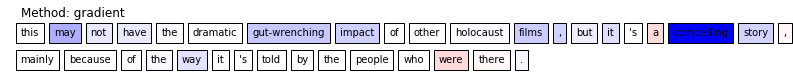

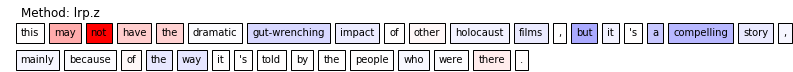

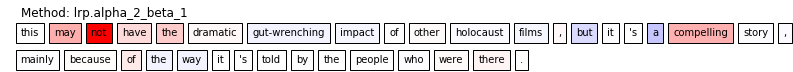

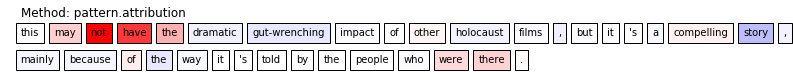

Review(id=726): without heavy-handedness , dong provides perspective with his intelligent grasp of human foibles and contradictions .
Pred class : positive ✓


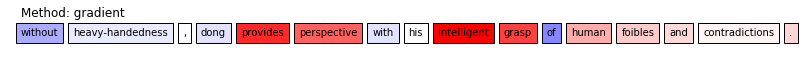

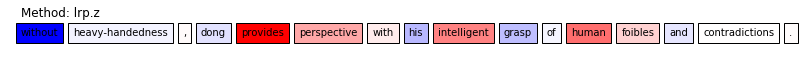

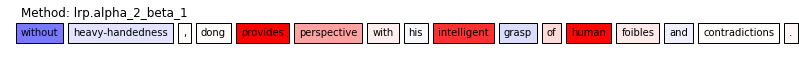

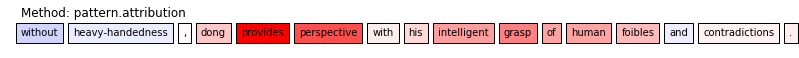

Review(id=908): a frantic search for laughs , with a hit-to-miss ratio that does n't exactly favour the audience .
Pred class : negative ✓


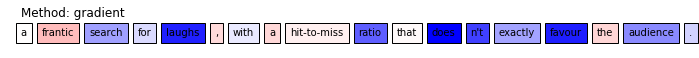

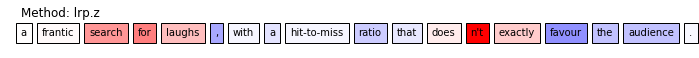

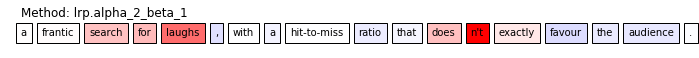

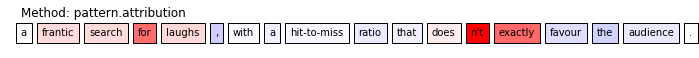

Review(id=1523): what you would end up with if you took orwell , bradbury , kafka , george lucas and the wachowski brothers and threw them into a blender .
Pred class : positive ✓


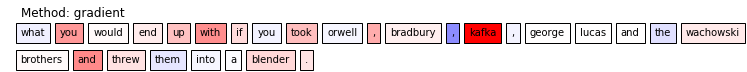

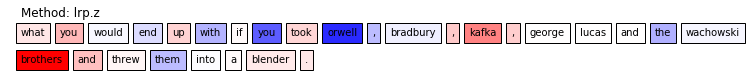

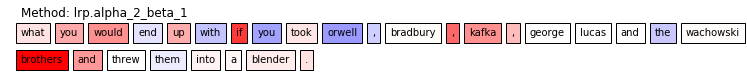

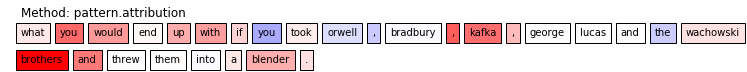

Review(id=454): a charming yet poignant tale of the irrevocable ties that bind .
Pred class : positive ✓


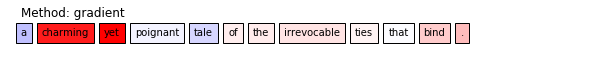

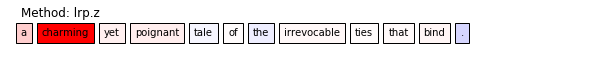

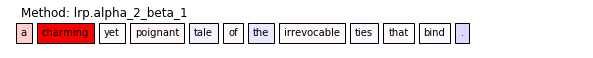

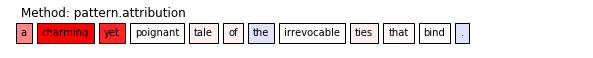

Review(id=539): but he loses his focus when he concentrates on any single person .
Pred class : negative ✓


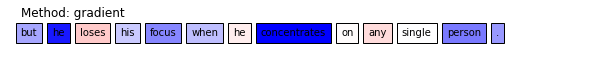

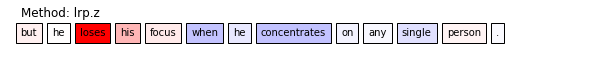

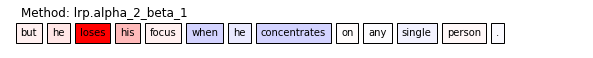

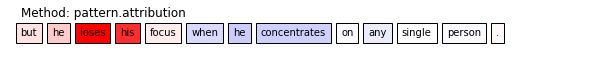

In [24]:
# Traverse over the analysis results and visualize them.
for i, idx in enumerate(test_sample_indices):

    words = [decode_dict[t] for t in list(datasets['test']['reviews'][idx])]
    
    print('Review(id=%d): %s' % (idx, ' '.join(words)))
    y_true = datasets['test']['targets'][idx]
    y_pred = test_sample_preds[i]

    print("Pred class : %s %s" % (LABEL_TO_CLASS_NAME[y_pred], '✓' if y_pred == y_true else '✗ (%s)' % LABEL_TO_CLASS_NAME[y_true]))
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()